In [18]:
import pandas as pd 
import numpy as np 
import pickle 
import os 
import io 
import re 
from sys import path 
import numpy as np 
import pickle 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer 
import matplotlib.pyplot as plt 
from string import punctuation, digits 
from IPython. core.display import display, HTML 
from nltk.corpus import stopwords 
from nltk. tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer 

In [19]:
#Amazon Data 
input_file = "data/amazon_cells_labelled.txt" 
amazon= pd.read_csv(input_file, delimiter='\t', header=None)
amazon.columns = ['Sentence', 'Class' ] 

#Yelp Data 
input_file = "data/yelp_labelled.txt" 
yelp= pd.read_csv(input_file, delimiter='\t', header=None)
yelp.columns = ['Sentence', 'Class' ] 


#imdb Data 
input_file = "data/imdb_labelled.txt" 
imdb= pd.read_csv(input_file, delimiter='\t', header=None)
imdb.columns = ['Sentence', 'Class' ] 

In [21]:
#combine all data sets 
data= pd.DataFrame() 
data= pd.concat([amazon,yelp,imdb])
data['index']= data.index

In [22]:
data

,Sentence,Class,index
0,So there is no way for me to plug it in here i...,0,0
1,"Good case, Excellent value.",1,1
2,Great for the jawbone.,1,2
3,Tied to charger for conversations lasting more...,0,3
4,The mic is great.,1,4
...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,743
744,"Unfortunately, any virtue in this film's produ...",0,744
745,"In a word, it is embarrassing.",0,745
746,Exceptionally bad!,0,746


   Class  COUNT
0      0    846
1      1    827


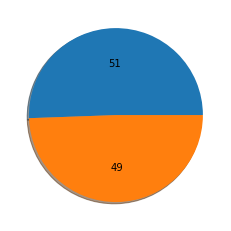

In [27]:
#Total Count of Each Category
pd.set_option('display.width', 4000)
pd.set_option('display.max_rows', 1000)
distofDetails = data.groupby(by='Class', as_index=False).\
                     agg({'index': pd.Series.nunique}).\
                     sort_values(by='index', ascending=False)

distofDetails.columns = ['Class', 'COUNT']
print(distofDetails)
#Distribution of All Categories
plt.pie(distofDetails['COUNT'], autopct='%1.0f', shadow=True, startangle=360)
plt.show()

In [64]:
#Text Prep rocessing 
columns = ['index','class', 'Sentence'] 
df_ =  pd.DataFrame(columns=columns) 

#lower string 
data['Sentence'] = data['Sentence'].str.lower() 

#remove numbers
data['Sentence'] = data["Sentence"].replace('\n', ' ', regex=True) 

#remove email adress
data['Sentence'] = data["Sentence"].replace('[a-zA-z0-9_.]+@[a-zA-Z0-9-_.]+', ' ', regex=True) 

#removeIP address 
data['Sentence'] = data["Sentence"].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', ' ', regex=True) 

#remove punctaitions and special chracters 
data['Sentence'] = data["Sentence"].replace('[^\W\S]', ' ', regex=True) 

#remove numbers
data['Sentence'] = data["Sentence"].replace('\d', ' ', regex=True) 

#removes top words
for index,row in data.iterrows(): 
    word_tokens = word_tokenize(row['Sentence'])
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('english')]
    df_ = df_.append({"index": row['index'], "Class": row['Class'],"Sentence": " ".join(filtered_sentence[0:])}, ignore_index=True) 

data = df_

In [65]:
X_train,X_test,y_train,y_test = train_test_split(data['Sentence'].values.astype( 'U'), data ['Class'].values.astype('int32'))
classes = data['Class'].unique()

In [66]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score 
from sklearn.neural_network import MLPClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import SGDClassifier 
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm = 'l2')
counts = vectorizer.fit_transform(X_train) 
vocab = vectorizer.vocabulary_ 
classifier= SGDClassifier(alpha=1e-05,max_iter=50, penalty='elasticnet') 
targets = y_train
classifier = classifier.fit(counts, targets)
example_counts = vectorizer.transform(X_test)
predictions = classifier.predict(example_counts)


from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import classification_report 
#Model Evaluation 
acc = accuracy_score(y_test, predictions, normalize=True) 
hit = precision_score(y_test, predictions, average=None,labels=classes) 
capture= recall_score(y_test, predictions, average=None, labels=classes) 

print('Model Accuracy:%.2f'%acc) 
print(classification_report(y_test,predictions))


Model Accuracy:0.79
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       349
           1       0.78      0.80      0.79       338

    accuracy                           0.79       687
   macro avg       0.79      0.79      0.79       687
weighted avg       0.79      0.79      0.79       687



In [67]:
pickle.dump(classifier, open("model_sentiment.pkl", "wb"))
pickle.dump(vocab, open("vocab_sentiment.pkl", "wb") )